Anita Soroush, 98222085, Computational Neuroscience, Project3

In [4]:
import matplotlib.pyplot as plt    
import numpy as np                 
import time      
import math       
import random

In [2]:
class LIF():
    def __init__(self, I, T=100, dt=0.1, neuron_type=1,
    V_th=-45, V_rest=-70, V_init=-80, V_reset=-65, V_spike=5, g_L=10, tau_m=8, 
    delta_T=1, theta_r_h=-55, a=0.01, b=0.5, tau_w=1):

        ### typical neuron parameters###
        self.neuron_type = neuron_type
        self.v_t = []
        self.fire_count = 0
        self.v = V_init
        self.V_init= V_init # initial potential [mV]
        self.V_th = V_th # spike threshold [mV]
        self.V_rest = V_rest #rest potential [mV]
        self.V_reset = V_reset #reset potential [mV]
        self.V_spike = V_spike
        self.g_L = g_L #leak conductance [nS]
        self.tau_m = tau_m # membrane time constant [ms]
        self.tau_w = tau_w

        ### simulation parameters ###
        self.I = I
        self.T = T # Total duration of simulation [ms]
        self.dt = dt  # Simulation time step [ms]


    def start(self):
        t = 0
        while t <= self.T:
            
            dv = (
                -(self.v - self.V_rest) 
                + self.I(t) * self.g_L
                )* (self.dt/self.tau_m)



            self.v += dv * self.dt
            if self.neuron_type == -1:
                print(self.v)
            is_spike = False
            if self.v >= self.V_th:
                self.v_t.append(self.v + self.V_spike)
                self.fire_count += 1
                self.v = self.V_reset
                is_spike = True

            else:
                self.v_t.append(self.v)

            t += self.dt

            yield {'u': self.v, 'is_spike': is_spike}


    def v_t_plot(self):
        plt.plot(list(map(lambda i: i * self.dt, range(len(self.v_t)))), self.v_t)
        plt.show()
        self.a

    def __repr__(self):
        return "This is object of class LIF"

In [13]:
class STDP_Learner_Population:

    def __init__(self, neurons, connections, init_connection_weights, delay=1, iteration_count=1000):
        self.neurons = neurons
        self.neroun_action = []
        for i in neurons:
            self.neroun_action.append(i.start())

        self.connections = connections                      # e.g. [(1, 3), (1, 5), (2, 4), (2, 3), (3, 5), (3, 4), (4, 1), (5, 2)]
                                                            # in this case (1, 3) means that neuron 1 is presynaptic to neuron 3

        self.connections_weights = init_connection_weights  # e.g. [3, 2, 5, 6, 9, 1, 10, 8]
                                                            # each element indicates the weight of the related connection in the list of the connections
                                                            # for example the third element here which is 5 relates to the third connection which is (2, 5)
        
        # self.w_init = w_init
        self.iteration_count = iteration_count
        self.spikes = []
        self.spikes_time = []
        self.delay = delay
        self.spikes_effect = []

        self.time_range = []
        self.w_t = [[0] * self.iteration_count for _ in range(len(connections))]

    def start(self):
        self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
        for t in range(self.iteration_count):
            self.time_range.append(t)
            flag = False
      
            for i in range(len(self.neroun_action)):

                action_info = next(self.neroun_action[i])
                if action_info['is_spike']:
                    self.spikes.append(i + 1)
                    self.spikes_time.append(t)

                    idx = 0
                    for connection in self.connections:

                        if connection[0] == i+1:   # if neuron i is the pre-synaptic neuron in this connection:
                            if t+self.delay < self.iteration_count:
                                self.spikes_effect[t + self.delay][connection[1]-1] += self.connections_weights[idx]

                            spike_idx = len(self.spikes)-1
                            for spike in reversed(self.spikes):
                                if spike == connection[1]:
                                    t_post_minus_t_pre = self.spikes_time[spike_idx] - t
                                    self.connections_weights[idx] = self.connections_weights[idx] + 25*math.exp(-abs(t_post_minus_t_pre)/5)
                                    # print(self.connections_weights)
                                    break
                                spike_idx -= 1

                        elif connection[1] == i+1: # if neuron i is the post-synaptic neuron in this connection:
                            for spike in reversed(self.spikes):
                                if spike == connection[0]:
                                    t_post_minus_t_pre = t - self.spikes_time[spike_idx]
                                    self.connections_weights[idx] = self.connections_weights[idx] - 25*math.exp(-abs(t_post_minus_t_pre)/5)
                                    break

                        idx += 1

                connection_idx = 0
                for connection_weight in self.connections_weights:
                    self.w_t[connection_idx][t] = self.connections_weights[connection_idx]
                    connection_idx += 1


            for i in range(len(self.neurons)):
                self.neurons[i].v += self.spikes_effect[t][i]

        print(self.connections_weights)
      

    def neurons_u_plot(self, neurons_count=5):
        legend = []
        for i in range(min(neurons_count, len(self.neurons))):
            plt.plot(list(map(lambda j: j * self.neurons[i].dt, range(len(self.neurons[i].v_t)))), self.neurons[i].v_t)
            legend.append('neuron ' + str(i+1))
        plt.legend(legend)

    def raster_plot(self):
        plt.scatter(self.spikes_time, self.spikes, color='blue', s=10)
    
    def w_t_plot(self, pre, post):
        idx=0
        for connection in self.connections:
            if connection[0] == pre and connection[1] == post:
                break
            idx += 1
        
        plt.plot(self.time_range, self.w_t[idx], color='blue')

In [14]:
# I1 = lambda x: 100
# I2 = lambda x: 1
# I3 = lambda x: 10

I1 = lambda x: 50
I2 = lambda x: 30
I3 = lambda x: 20

neuron1 = LIF(I=I1, tau_m=20)
neuron2 = LIF(I=I2, tau_m=20)
neuron3 = LIF(I=I3, tau_m=20)

neurons = [neuron1, neuron2, neuron3]

connections = [(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]
init_connection_weights = [10, 10, 10, 10, 10, 10]

In [15]:
STDP_learner_population = STDP_Learner_Population(neurons, connections, init_connection_weights, delay=1, iteration_count=1000)
STDP_learner_population.start()

[-3.764743276150938, 1.7580021872834368, -6.161019526329569, 1.7580011508910263, -5.982462533189049, 10.000000000001524]


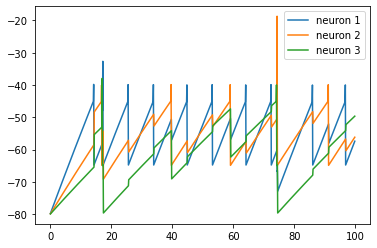

In [16]:
STDP_learner_population.neurons_u_plot()

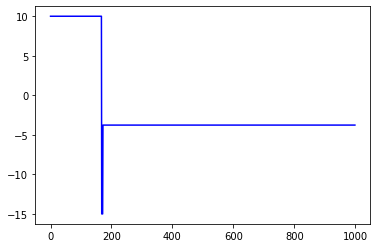

In [17]:
STDP_learner_population.w_t_plot(1,2)

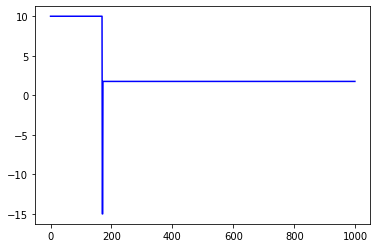

In [18]:
STDP_learner_population.w_t_plot(1,3)

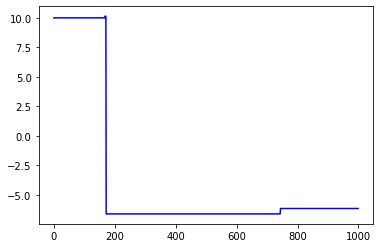

In [19]:
STDP_learner_population.w_t_plot(2,1)

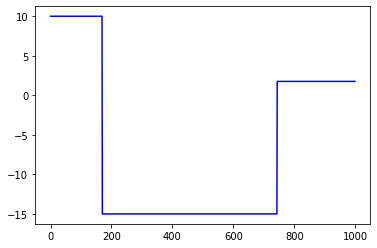

In [20]:
STDP_learner_population.w_t_plot(2,3)

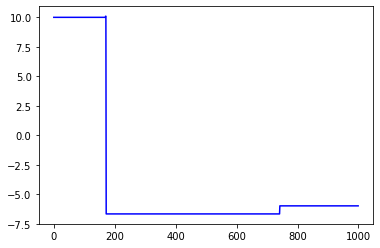

In [21]:
STDP_learner_population.w_t_plot(3,1)

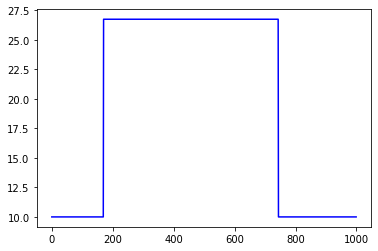

In [22]:
STDP_learner_population.w_t_plot(3,2)

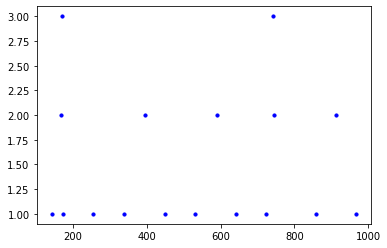

In [23]:
STDP_learner_population.raster_plot()

In [24]:
I1 = lambda x: 20* (math.sin(x/10) + 0.9)
I1 = lambda x: 50
I2 = lambda x: 80* (math.sin(x/10) + 0.9)

neuron1 = LIF(I=I1, tau_m=20)
neuron2 = LIF(I=I2, tau_m=20)
neuron3 = LIF(I=I3, tau_m=20)

neurons = [neuron1, neuron2, neuron3]

connections = [(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]
init_connection_weights = [10, 10, 10, 10, 10, 10]

In [25]:
STDP_learner_population = STDP_Learner_Population(neurons, connections, init_connection_weights, delay=1, iteration_count=1000)
STDP_learner_population.start()

[3024.2822544003593, -14.958460897062762, 3031.561598375236, 1.8199702105708213, 23.678751799413426, 9.938030940320163]


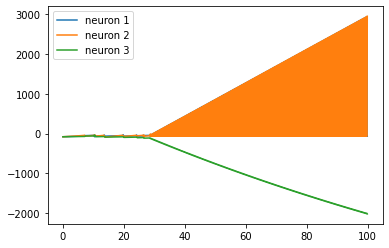

In [26]:
STDP_learner_population.neurons_u_plot()

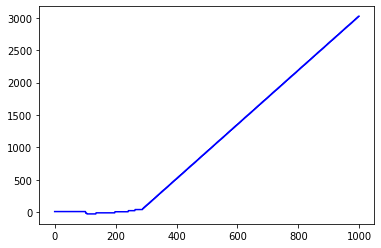

In [27]:
STDP_learner_population.w_t_plot(1,2)

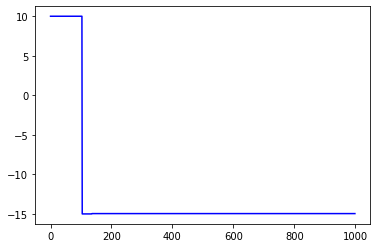

In [28]:
STDP_learner_population.w_t_plot(1,3)

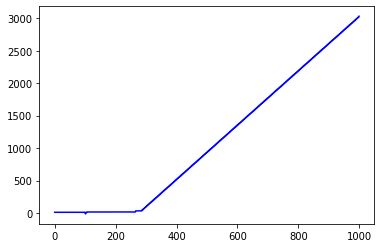

In [29]:
STDP_learner_population.w_t_plot(2,1)

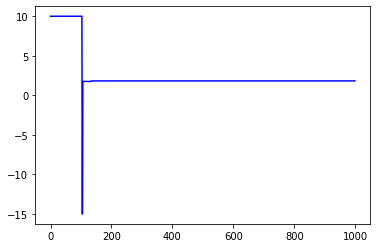

In [30]:
STDP_learner_population.w_t_plot(2,3)

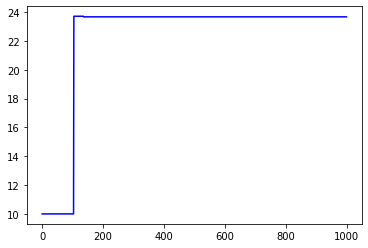

In [31]:
STDP_learner_population.w_t_plot(3,1)

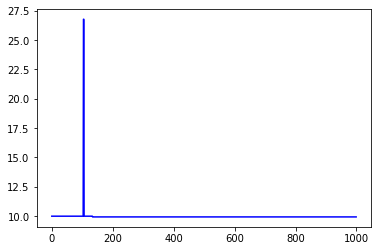

In [32]:
STDP_learner_population.w_t_plot(3,2)

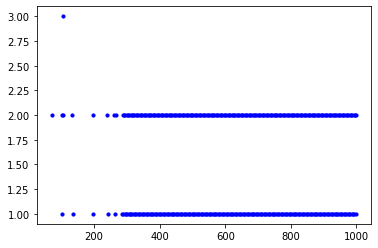

In [33]:
STDP_learner_population.raster_plot()

In [41]:
class Reward_Based_STDP_Learner_Population:

    def __init__(self, neurons, connections, init_connection_weights ,output_layer, 
                 target_neuron, mode='train', delay=1, iteration_count=1000):
        self.neurons = neurons
        self.mode = mode
        self.output_layer = output_layer
        self.target_neuron = target_neuron
        self.neroun_action = []
        for i in neurons:
            self.neroun_action.append(i.start())

        self.connections = connections                      # e.g. [(1, 3), (1, 5), (2, 4), (2, 3), (3, 5), (3, 4), (4, 1), (5, 2)]
                                                            # in this case (1, 3) means that neuron 1 is presynaptic to neuron 3

        self.connections_weights = init_connection_weights  # e.g. [3, 2, 5, 6, 9, 1, 10, 8]
                                                            # each element indicates the weight of the related connection in the list of the connections
                                                            # for example the third element here which is 5 relates to the third connection which is (2, 5)
        
        # self.w_init = w_init
        self.iteration_count = iteration_count
        self.spikes = []
        self.spikes_time = []
        self.delay = delay
        self.spikes_effect = []

        self.time_range = []
        self.w_t = [[0] * self.iteration_count for _ in range(len(connections))]

    def start(self):
        self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
        for t in range(self.iteration_count):
            self.time_range.append(t)
            flag = False
      
            for i in range(len(self.neroun_action)):

                action_info = next(self.neroun_action[i])

                if action_info['is_spike']:
                    if i+1 in self.output_layer:

                        # just train mode:
                        if self.mode == 'train':
                            if i+1 == self.target_neuron:
                                DA = 10
                            else:
                                DA = 1/2
                            connection_idx = 0
                            for connection_weight in self.connections_weights:
                                self.connections_weights[connection_idx] *= DA
                                connection_idx += 1

                        # just test mode:
                        if self.mode == 'test':
                            return self.connections_weights, t, i+1 == self.target_neuron


                    self.spikes.append(i + 1)
                    self.spikes_time.append(t)

                    idx = 0
                    for connection in self.connections:

                        if connection[0] == i+1:   # if neuron i is the pre-synaptic neuron in this connection:
                            
                            # both test mode and train mode:
                            if t+self.delay < self.iteration_count:
                                self.spikes_effect[t + self.delay][connection[1]-1] += self.connections_weights[idx]


                            # just train mode:
                            if self.mode == 'train':
                                spike_idx = len(self.spikes)-1
                                for spike in reversed(self.spikes):
                                    if spike == connection[1]:
                                        t_post_minus_t_pre = self.spikes_time[spike_idx] - t
                                        self.connections_weights[idx] = self.connections_weights[idx] + 25*math.exp(-abs(t_post_minus_t_pre)/5)
                                        # print(self.connections_weights)
                                        break
                                    spike_idx -= 1


                        elif connection[1] == i+1: # if neuron i is the post-synaptic neuron in this connection:

                            # just train mode:
                            if self.mode == 'train':
                                for spike in reversed(self.spikes):
                                    if spike == connection[0]:
                                        t_post_minus_t_pre = t - self.spikes_time[spike_idx]
                                        self.connections_weights[idx] = self.connections_weights[idx] - 25*math.exp(-abs(t_post_minus_t_pre)/5)
                                        break

                        idx += 1
                
                
                connection_idx = 0
                for connection_weight in self.connections_weights:
                    self.w_t[connection_idx][t] = self.connections_weights[connection_idx]
                    connection_idx += 1

            for i in range(len(self.neurons)):
                self.neurons[i].v += self.spikes_effect[t][i]

        if self.mode == 'train':
            return self.connections_weights, self.iteration_count
        else: 
            return self.connections_weights, self.iteration_count, False
      

    def neurons_u_plot(self):
        legend = []
        for i in range(len(self.neurons)):
            plt.plot(list(map(lambda j: j * self.neurons[i].dt, range(len(self.neurons[i].v_t)))), self.neurons[i].v_t)
            legend.append('neuron ' + str(i+1))
        plt.legend(legend)

    def raster_plot(self):
        plt.scatter(self.spikes_time, self.spikes, color='blue', s=10)

    def w_t_plot(self):
        plt.figure(0)
        plots = []
        idx=0
        for i in range(5):
            for j in range(2):
                ax = plt.subplot2grid((5,2), (i,j))
                ax.plot(self.time_range, self.w_t[idx], color='blue')
                # ax.legend('pre-synaptic:', connections[idx][0], '\npost-synaptic:', connections[idx][1])
                # title = 'pre-synaptic:'+ str(connections[idx][0])+ '\npost-synaptic:'+ str(connections[idx][1])
                # ax.text(title)
                idx += 1
        plt.show()

    def w_t_plot(self, pre, post):
        idx=0
        for connection in self.connections:
            if connection[0] == pre and connection[1] == post:
                break
            idx += 1
        
        plt.plot(self.time_range, self.w_t[idx], color='blue')

In [42]:
def traing_step(step_number, input_currents, target_neuron, connection_weights):
    neurons = []

    # input layer:
    for iterator in range(5):
        neurons.append(LIF(I=lambda x: input_currents[iterator]*10, tau_m=20))

    # output layer
    for iterator in range(2):
        neurons.append(LIF(I=lambda x: 0, tau_m=20))

    connections =  [(1, 6), (1, 7), 
                    (2, 6), (2, 7), 
                    (3, 6), (3, 7), 
                    (4, 6), (4, 7), 
                    (5, 6), (5, 7)]
    if step_number == 1:
        connection_weights=[10, 10, 
                            10, 10, 
                            10, 10,
                            10, 10,
                            10, 10]
    reward_based_STDP_learner_population = Reward_Based_STDP_Learner_Population(neurons, connections, connection_weights, 
                                            delay=1, iteration_count=1000, output_layer = [6,7], target_neuron = target_neuron + 6, mode='train')
    connection_weights, ending_iteration = reward_based_STDP_learner_population.start()
    print(ending_iteration)
    return connection_weights

In [43]:
def testing_step(input_currents, target_neuron, connection_weights):
    neurons = []

    # input layer:
    for iterator in range(5):
        neurons.append(LIF(I=lambda x: input_currents[iterator]*10, tau_m=20))

    # output layer
    for iterator in range(2):
        neurons.append(LIF(I=lambda x: 0, tau_m=20))

    connections =  [(1, 6), (1, 7), 
                    (2, 6), (2, 7), 
                    (3, 6), (3, 7), 
                    (4, 6), (4, 7), 
                    (5, 6), (5, 7)]

    reward_based_STDP_learner_population = Reward_Based_STDP_Learner_Population(neurons, connections, connection_weights, 
                                            delay=1, iteration_count=1000, output_layer = [6,7], target_neuron = target_neuron + 6, mode='test')
    connection_weights, ending_iteration, last_spike = reward_based_STDP_learner_population.start()
    print(ending_iteration)
    print(last_spike)
    return connection_weights

In [44]:
train= [([1,1,0,0,0], 1), 
        ([2,1,1,0,0], 1), 
        ([3,1,0,0,0], 1), 
        ([2,0,0,0,0], 1), 
        ([1,1,0,0,1], 0), 
        ([1,0,0,0,2], 0), 
        ([0,1,0,3,0], 0), 
        ([0,0,0,1,1], 0), 
        ([0,0,0,0,1], 0), 
        ([2,2,2,1,2], 1)]

In [45]:
connection_weights = []
learning_step = 1
for data in train:
    connection_weights= traing_step(step_number = learning_step, 
                                    input_currents = data[0], 
                                    target_neuron = data[1], 
                                    connection_weights = connection_weights)
    print(connection_weights)
    learning_step += 1

1000
[-200.0, 25.0, -200.0, 25.0, -200.0, 25.0, -200.0, 25.0, -200.0, 25.0]
1000
[-2000.0, 225.0, -2000.0, 225.0, -2000.0, 225.0, -2000.0, 225.0, -2000.0, 225.0]
1000
[-20000.0, 2225.0, -20000.0, 2225.0, -20000.0, 2225.0, -20000.0, 2225.0, -20000.0, 2225.0]
1000
[-20000.0, 2225.0, -20000.0, 2225.0, -20000.0, 2225.0, -20000.0, 2225.0, -20000.0, 2225.0]
1000
[-10000.0, 1087.5, -10000.0, 1087.5, -10000.0, 1087.5, -10000.0, 1087.5, -10000.0, 1087.5]
1000
[-10000.0, 1087.5, -10000.0, 1087.5, -10000.0, 1087.5, -10000.0, 1087.5, -10000.0, 1087.5]
1000
[-5000.0, 518.75, -5000.0, 518.75, -5000.0, 518.75, -5000.0, 518.75, -5000.0, 518.75]
1000
[-5000.0, 518.75, -5000.0, 518.75, -5000.0, 518.75, -5000.0, 518.75, -5000.0, 518.75]
1000
[-5000.0, 518.75, -5000.0, 518.75, -5000.0, 518.75, -5000.0, 518.75, -5000.0, 518.75]
1000
[-5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0]


In [46]:
test = [([1,0,0,0,0], 1), 
        ([0,1,0,0,0], 1), 
        ([0,2,0,0,0], 1), 
        ([2,2,1,0,0], 1), 
        ([1,2,0,0,0], 1), 
        ([1,0,0,0,3], 0), 
        ([3,1,0,2,3], 0), 
        ([0,0,2,2,2], 0), 
        ([1,2,0,1,1], 1), 
        ([2,2,2,3,3], 0)]

In [47]:
for data in test:
    connection_weights= testing_step(input_currents = data[0], 
                                    target_neuron = data[1], 
                                    connection_weights = connection_weights)
    print(connection_weights)

1000
False
[-5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0]
767
True
[-5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0]
366
True
[-5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0]
366
True
[-5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0]
366
True
[-5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0]
1000
False
[-5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0]
767
False
[-5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0]
1000
False
[-5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0, -5000000.0, 516250.0]
366
True
[-5000000.0, 516250.0, -